In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np

BASE = Path("/content/drive/MyDrive/biolip_gnn")
SUBSET_PATH = BASE / "out" / "subset_200.csv"
STRUCT_DIR  = BASE / "structures"
GRAPHS_DIR  = BASE / "graphs"
GRAPHS_DIR.mkdir(exist_ok=True)

df = pd.read_csv(SUBSET_PATH)
print("Loaded subset rows:", len(df))
print("Structures present:", len(list(STRUCT_DIR.glob("*.cif.gz"))))
print("Graphs will save to:", GRAPHS_DIR)


Mounted at /content/drive
Loaded subset rows: 200
Structures present: 200
Graphs will save to: /content/drive/MyDrive/biolip_gnn/graphs


In [2]:
# defining parse_chain() again
!pip -q install biopython

import gzip
from Bio.PDB import MMCIFParser
from Bio.PDB.Polypeptide import is_aa

parser = MMCIFParser(QUIET=True)

def _get_local_cif_path(pdb_id: str, struct_dir: Path) -> Path:
    pdb = pdb_id.strip().lower()
    gz_path = struct_dir / f"{pdb}.cif.gz"
    tmp_cif  = Path("/tmp") / f"{pdb}.cif"

    if tmp_cif.exists() and tmp_cif.stat().st_size > 0:
        return tmp_cif

    if gz_path.exists() and gz_path.stat().st_size > 0:
        with gzip.open(str(gz_path), "rb") as f_in:
            tmp_cif.write_bytes(f_in.read())
        return tmp_cif

    raise FileNotFoundError(f"Missing CIF for {pdb_id}. Expected: {gz_path}")

def parse_chain(pdb_id: str, chain_id: str, struct_dir: Path):
    pdb_id = str(pdb_id).strip()
    chain_id = str(chain_id).strip()

    cif_local = _get_local_cif_path(pdb_id, struct_dir)
    structure = parser.get_structure(pdb_id, str(cif_local))
    model = next(structure.get_models())

    chains = [c.id for c in model.get_chains()]
    if chain_id not in chains:
        raise KeyError(f"Chain '{chain_id}' not found in {pdb_id}. Available chains: {chains}")

    chain = model[chain_id]

    residues_out, n_ca = [], 0
    for res in chain.get_residues():
        if not is_aa(res, standard=True):
            continue
        if "CA" not in res:
            continue

        het, resseq, icode = res.get_id()
        residues_out.append({
            "resname": res.get_resname(),
            "resseq": int(resseq),
            "icode": str(icode).strip(),
            "ca": np.array(res["CA"].get_coord(), dtype=float)
        })
        n_ca += 1

    return {"pdb_id": pdb_id, "chain": chain_id, "residues": residues_out}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.9 MB/s eta 0:00:00


In [4]:
# define amino-acid encoding (node features)

AA20 = ["ALA","CYS","ASP","GLU","PHE","GLY","HIS","ILE","LYS","LEU",
       "MET","ASN","PRO","GLN","ARG","SER","THR","VAL","TRP","TYR"]

aa_to_idx = {aa:i for i, aa in enumerate(AA20)}
UNK_IDX = len(AA20)

def resname_to_idx(resname: str) -> int:
  return aa_to_idx.get(resname.upper(), UNK_IDX)

In [9]:
# building the graph

def make_graph(pdb_id: str, chain_id: str, struct_dir: Path, dist_threshold: float = 8.0):
    parsed = parse_chain(pdb_id, chain_id, struct_dir)
    residues = parsed["residues"]
    n = len(residues)
    if n < 2:
        raise ValueError(f"Too few residues parsed for {pdb_id} {chain_id}: n={n}")

    coords = np.vstack([r["ca"] for r in residues])
    x_idx = np.array([resname_to_idx(r["resname"]) for r in residues], dtype=np.int64)  # (n,)

    # Pairwise distances (O(n^2), but n<=500 so fine for 50 proteins)
    diff = coords[:, None, :] - coords[None, :, :]
    dists = np.sqrt((diff**2).sum(axis=-1))

    # Contact edges: i!=j and dist < threshold
    contact_mask = (dists < dist_threshold) & (dists > 0)
    src, dst = np.where(contact_mask)

    # Add sequence edges i<->i+1
    seq_src = np.arange(n-1)
    seq_dst = seq_src + 1
    src = np.concatenate([src, seq_src, seq_dst])
    dst = np.concatenate([dst, seq_dst, seq_src])

    edge_index = np.vstack([src, dst]).astype(np.int64)  # (2, E)
    edge_dist = dists[edge_index[0], edge_index[1]].astype(np.float32)  # (E,)

    # Also store residue indices (resseq) for traceability
    resseq = np.array([r["resseq"] for r in residues], dtype=np.int32)

    return {
        "pdb_id": pdb_id,
        "chain": chain_id,
        "coords": coords.astype(np.float32),     # (n,3)
        "x_idx": x_idx,                          # (n,)
        "edge_index": edge_index,                # (2,E)
        "edge_dist": edge_dist,                  # (E,)
        "resseq": resseq,                        # (n,)
        "n_nodes": n,
        "n_edges": edge_index.shape[1]
    }


In [10]:
import json

N_GRAPHS = 50
sample50 = df.sample(n=N_GRAPHS, random_state=42).reset_index(drop=True)

saved = 0
failed = []

for _, r in sample50.iterrows():
    pdb_id = r["pdb_id"]
    chain  = r["chain"]
    out_path = GRAPHS_DIR / f"{pdb_id}_{chain}.npz"

    try:
        g = make_graph(pdb_id, chain, STRUCT_DIR, dist_threshold=8.0)
        np.savez_compressed(
            out_path,
            pdb_id=g["pdb_id"],
            chain=g["chain"],
            coords=g["coords"],
            x_idx=g["x_idx"],
            edge_index=g["edge_index"],
            edge_dist=g["edge_dist"],
            resseq=g["resseq"],
            n_nodes=g["n_nodes"],
            n_edges=g["n_edges"],
        )
        saved += 1
    except Exception as e:
        failed.append({"pdb_id": pdb_id, "chain": chain, "error": str(e)})

print("Saved graphs:", saved)
print("Failed graphs:", len(failed))

# Save failure log
log_path = GRAPHS_DIR / "day4_failures.json"
log_path.write_text(json.dumps(failed, indent=2), encoding="utf-8")
print("Failure log:", log_path)

Saved graphs: 50
Failed graphs: 0
Failure log: /content/drive/MyDrive/biolip_gnn/graphs/day4_failures.json


Graphs on disk: 50


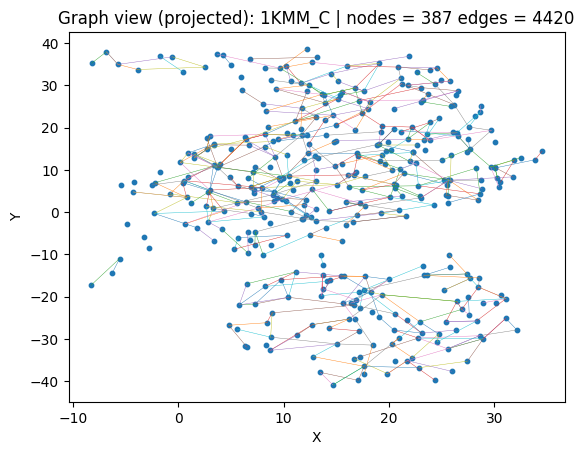

Saved figure to: /content/drive/MyDrive/biolip_gnn/out/day4_graph_visual_1KMM_C.png


<Figure size 640x480 with 0 Axes>

In [12]:
# quick visualization of one graph

import matplotlib.pyplot as plt

OUT_FIG_DIR = Path("/content/drive/MyDrive/biolip_gnn/out")
OUT_FIG_DIR.mkdir(exist_ok=True)

npz_files = sorted(GRAPHS_DIR.glob("*.npz"))
print("Graphs on disk:", len(npz_files))
example = npz_files[0]
data = np.load(example, allow_pickle=True)

coords = data["coords"]
edge_index = data["edge_index"]

# Sample up to 500 edges to draw
E = edge_index.shape[1]
take = min(E, 500)
idx = np.random.RandomState(0).choice(E, size=take, replace=False)
ei = edge_index[:, idx]

plt.figure()
plt.scatter(coords[:,0], coords[:, 1], s=10)

for s, t in ei.T:
  plt.plot([coords[s, 0], coords[t, 0]], [coords[s, 1], coords[t, 1]], linewidth=0.3)

plt.title(f"Graph view (projected): {example.stem} | nodes = {coords.shape[0]} edges = {E}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

fig_path = OUT_FIG_DIR / f"day4_graph_visual_{example.stem}.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
print("Saved figure to:", fig_path)